In [54]:
from tqdm import tqdm 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import medmnist 
from medmnist import INFO, Evaluator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_auc_score

In [5]:
print(f'MEDMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}')

MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [18]:
#data_flag = 'pneumoniamnist'
data_flag = 'organamnist'
# data_flag = 'breatmnist'
download = 'True'

epochs = 20
BATCH_SIZE = 32
lr = 0.001
num_workers = 4 # number of parallel processes for data preparation

info = INFO[data_flag]
task = info['task'] # multiclass
n_channels = info['n_channels'] # 3 channels
n_classes = len(info['label']) # 9 classes
class_names = info['label']
DataClass = getattr(medmnist, info['python_class'])

In [19]:
print(f"The number of classes is: {n_classes}, and the number of channels is: {n_channels}.")

The number of classes is: 11, and the number of channels is: 1.


In [20]:
class_names

{'0': 'bladder',
 '1': 'femur-left',
 '2': 'femur-right',
 '3': 'heart',
 '4': 'kidney-left',
 '5': 'kidney-right',
 '6': 'liver',
 '7': 'lung-left',
 '8': 'lung-right',
 '9': 'pancreas',
 '10': 'spleen'}

In [21]:
print(info)

{'python_class': 'OrganAMNIST', 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/organamnist.npz?download=1', 'MD5': '866b832ed4eeba67bfb9edee1d5544e6', 'task': 'multi-class', 'label': {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart

In [22]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5,9),sigma = (0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[.5])
])


# Load the data
train_dataset = DataClass(split ='train', transform = data_transform, download=download)
test_dataset = DataClass(split='test', transform = data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)
train_loader_at_eval = data.DataLoader(dataset = train_dataset, batch_size = 2*BATCH_SIZE, shuffle = False, num_workers = num_workers)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)




Using downloaded and verified file: C:\Users\Theodora\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\organamnist.npz


In [23]:
print(train_dataset)
print('='*50)
print(test_dataset)

Dataset OrganAMNIST (organamnist)
    Number of datapoints: 34581
    Root location: C:\Users\Theodora\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34581, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-cl

In [24]:
len(train_loader), len(test_loader), len(train_loader_at_eval)

(1081, 17778, 541)

In [25]:
# Visualization
train_dataset.montage(length=1)

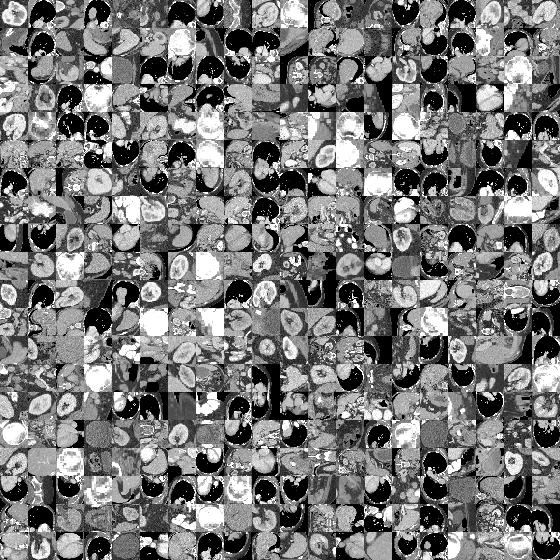

In [26]:
# montage
train_dataset.montage(length=20)

In [27]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes, p):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size = 3, stride = 1, padding = 1), # input size = 32, conv2d = 32, conv2d = 32, maxpool2d = 16
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = 1),   # input size = 16, conv2d = 16, conv2d = 16, maxpooling = 8
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size = 3, stride =1, padding = 1),
        nn.ReLU(),
        #nn.BatchNorm2d
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), # input_size = 8, conv2d = 8, conv2d = 8, maxpool = 4
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size = 3, stride =1, padding = 1),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*4*4, 240),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(240, num_classes)
        )
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return(x)
        



In [43]:
class LeNet(nn.Module):
    def __init__(self, input_channels, num_classes, p):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(input_channels,24,5),
        nn.ReLU(),
        nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(
        nn.Conv2d(24, 48, 5),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2))

        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(48*5*5, 240),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(240, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc(x)
        return x
    


In [55]:
class ConvNet2(nn.Module):
    def __init__(self, in_channels, num_classes, p):
        super(ConvNet2, self).__init__()
        self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels = 32, kernel_size=3),   # input size = 32, conv2d: 30, maxPool: 15
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(32, 64,3),    # input size = 15, conv2d:  
        nn.ReLU(),
        #nn.Dropout(p),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128, 256, 1),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 128),
            nn.Dropout2d(p=0.4),
            nn.Linear(in_features = 128, out_features = num_classes))
        
    def forward(self, x):
        x= self.conv_block(x)
        #print(x.shape)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x,1).reshape(bs, -1)
        x = self.classifier(x)
        return x
        


In [56]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0.0
    counter = 0
    for i, (image, labels) in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        #image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        
        # Calculate the loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
            
        train_running_loss += loss.item()
        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds==labels).sum().item()
        # Backpropagation
        loss.backward()
        #Update teh weights
        optimizer.step()
        
    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss/counter
    epoch_acc = 100.*(train_running_correct/ len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [57]:
len(train_loader.dataset)

34581

In [58]:
if __name__ == '__main__':
    # Criterion
    if task == 'multi-label, binary-class':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
        
    # model selection
    model = LeNet(n_channels, n_classes, p=0.5)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Loss function
    optimizer = optim.SGD(model.parameters(), lr, momentum = 0.9)
    
    # Lists to keep track of losses and accuracies
    train_loss = []
    train_acc = []
    # Starting the training
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        
        print(f"Training Loss: {train_epoch_loss:.3f}, training_acc: {train_epoch_acc:.3f}")
        print ('='*50)


[INFO]: Epoch 1 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 160.03it/s]


Training Loss: 1.465, training_acc: 48.110
[INFO]: Epoch 2 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 159.91it/s]


Training Loss: 0.927, training_acc: 67.309
[INFO]: Epoch 3 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 156.98it/s]


Training Loss: 0.743, training_acc: 74.107
[INFO]: Epoch 4 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 156.20it/s]


Training Loss: 0.630, training_acc: 78.320
[INFO]: Epoch 5 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 155.78it/s]


Training Loss: 0.551, training_acc: 80.935
[INFO]: Epoch 6 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 159.83it/s]


Training Loss: 0.502, training_acc: 82.762
[INFO]: Epoch 7 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 159.29it/s]


Training Loss: 0.464, training_acc: 83.832
[INFO]: Epoch 8 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 158.57it/s]


Training Loss: 0.427, training_acc: 85.226
[INFO]: Epoch 9 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 157.58it/s]


Training Loss: 0.403, training_acc: 86.076
[INFO]: Epoch 10 of 20
Training


100%|██████████| 1081/1081 [00:07<00:00, 151.84it/s]


Training Loss: 0.375, training_acc: 86.866
[INFO]: Epoch 11 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 156.93it/s]


Training Loss: 0.356, training_acc: 87.820
[INFO]: Epoch 12 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 157.08it/s]


Training Loss: 0.335, training_acc: 88.404
[INFO]: Epoch 13 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 159.69it/s]


Training Loss: 0.312, training_acc: 89.231
[INFO]: Epoch 14 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 161.59it/s]


Training Loss: 0.303, training_acc: 89.445
[INFO]: Epoch 15 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 162.82it/s]


Training Loss: 0.288, training_acc: 90.128
[INFO]: Epoch 16 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 160.84it/s]


Training Loss: 0.278, training_acc: 90.304
[INFO]: Epoch 17 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 156.67it/s]


Training Loss: 0.264, training_acc: 91.067
[INFO]: Epoch 18 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 158.61it/s]


Training Loss: 0.251, training_acc: 91.380
[INFO]: Epoch 19 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 162.00it/s]


Training Loss: 0.245, training_acc: 91.362
[INFO]: Epoch 20 of 20
Training


100%|██████████| 1081/1081 [00:06<00:00, 159.08it/s]

Training Loss: 0.233, training_acc: 92.030


ConvNet gave a training accuracy at the 20th epoch: 96.582  
ConvNet gave a testing accuracy: 85.797

LeNet gave a training accuracy at the 20th epoch: 91.663  
LeNet gave a testing accuracy: 81.741

ConvNet2 gave a training accuracy at the 20th epoch: 92.030
ConvNet2 gave a testing accuracy: 81.640
    

In [59]:
def test(model, testloader):
    model.eval()
    print('Testing the model')
    prediction_list=[]
    ground_truth_list=[]
    test_running_correct=0
    counter=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            # softmax probabilities
            predictions = F.softmax(outputs,1).cpu().numpy()
            # Predicted class number
            output_class = np.argmax(predictions)
            # Append the GT and predictions to the respective lists
            prediction_list.append(output_class)
            ground_truth_list.append(labels.cpu().numpy())
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds==labels.squeeze().long()).sum().item()
            # Save a few test images.
            if counter % 999 == 0:
                save_test_results(image, labels, output_class, counter)
        acc = 100. * (test_running_correct / len(testloader.dataset))
        return prediction_list, ground_truth_list, acc


In [60]:
def save_test_results(tensor, labels, output_class, counter):
    '''
    This function will save a few test images along with the
    ground truth label and predicted label annotated on the image
    
    :param tensor: the image tensor
    :param target: the ground truth class
    param output_class: the predicted class number
    param counter: the test image number
    '''
    
    # Move tensor to cpu and denormalize
    image = torch.squeeze(tensor, 0).cpu().numpy()
    image = image/2 + 0.5
    image = np.transpose(image, (1,2,0))
    # Convert to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gt = labels.cpu().numpy()
    cv2.putText(
    image, f"GT: {gt}",
    (5,25), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(
    image, f"Pred: {output_class}",
    (5, 55), cv2.FONT_HERSHEY_SIMPLEX, 
    0.7, (0,255,0), 2, cv2.LINE_AA)
    
    cv2.imwrite(f"../outputs/test_image_{counter}.png", image*255.)
    
    
  

In [61]:
 def test(model, testloader):
    model.eval()
    print('Testing the model')
    predictions_list=[]
    ground_truth_list=[]
    test_running_correct=0
    counter=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            # softmax probabilities
            predictions = F.softmax(outputs,1).cpu().numpy()
            # Predicted class number
            output_class = np.argmax(predictions)
            #output_class = np.column_stack(output_class)
            # Append the GT and predictions to the respective lists
            predictions_list.append(output_class)
            ground_truth_list.append(labels.squeeze().long().cpu().numpy())
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds==labels.squeeze().long()).sum().item()
            #Save a few test images.
            if counter % 999 == 0:
                save_test_results(image, labels, output_class, counter)
        acc = 100. * (test_running_correct / len(testloader.dataset))
        return predictions_list, ground_truth_list, acc

    
    

In [62]:
if __name__ == '__main__':
    
    prediction_list, ground_truth_list, acc = test(model, test_loader)
    print(f"Test accuracy: {acc:.3f}%")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(ground_truth_list, prediction_list)
    
    plt.figure(figsize=(12,9))

    sns.heatmap(
    conf_matrix, 
    annot = True,
    xticklabels = class_names,
    yticklabels = class_names)
    
    plt.savefig('../outputs/heatmaps_ConvNet2.png')
    plt.close()


Testing the model


100%|██████████| 17778/17778 [00:36<00:00, 484.23it/s]


Test accuracy: 81.640%
